This code imports buoy data, processes it by removing NaNs and filling in time gaps, and then plots a time series for the selected IOP days.

To run, update the ds variable to be the path to your buoy data, and be sure to change the selection to show the right location.


Made by Paige Bartels on 10/29/2024

Required packages: Numpy, Matplotlib, Pandas

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
def averageWindDirection(wind_directions):
    # Convert degrees to radians
    wind_directions_rad = np.radians(wind_directions)

    # Calculate the unit vectors for each direction
    u_components = np.cos(wind_directions_rad)
    v_components = np.sin(wind_directions_rad)

    # Calculate the average unit vector
    mean_u = np.mean(u_components)
    mean_v = np.mean(v_components)

    # Convert the average unit vector back to degrees
    average_direction_rad = np.arctan2(mean_v, mean_u)
    average_direction_deg = np.degrees(average_direction_rad)

    # Adjust the average direction to be between 0 and 360 degrees
    if average_direction_deg < 0:
        average_direction_deg += 360

    return average_direction_deg

In [4]:
# List location of file
ds='/content/drive/MyDrive/Colab Notebooks/2024 LITESC Project Experimental Plan/Photos and Data/Buoy Data - Corrected CSV/buoydata_45023.csv'

In [106]:
# See this link for description of values: https://www.ndbc.noaa.gov/faq/measdes.shtml#stdmet
data=pd.read_csv(ds, header=1, skiprows=[2]) #Loading in data as pandas DataFrame
data=data.replace(to_replace='MM',value='NaN') # Replacing "MM" values with NaN


# Shifting time from EDT (UTC-4), accounting for day and month changes
data['hh']=data['hh']+4
data.loc[data['hh']>=24,'DD']=data['DD']+1
data.loc[data['hh']>=24,'hh']=data['hh']-24
data.loc[data['DD']>30,'MM']=data['MM']+1

# Creating two-digit (padded) times
data['hh']=data['hh'].astype('str')
data['MM']=data['MM'].astype('str')
data['mm']=data['mm'].astype('str')
data['DD']=data['DD'].astype('str')

data.loc[data['hh'].astype('int')<10,'hh']='0'+data['hh']
data.loc[data['mm'].astype('int')<10,'mm']='0'+data['mm']
data.loc[data['MM'].astype('int')<10,'MM']='0'+data['MM']
data.loc[data['DD'].astype('int')<10,'DD']='0'+data['DD']

# Adding datetime
data['Date']=data['#YY'].astype('str')+data['MM']+data['DD']+' '+data['hh']+':'+data['mm']

# Reversing data, so chronological
data = data.iloc[::-1]
data.reset_index(drop=True, inplace=True) # Resetting index of table

#data

In [107]:
# Selecting IOP days for McLain (45023)
iop_days=data.where(data['MM'].astype('int')==10).where(data['DD'].astype('int')>=12).where(data['DD'].astype('int')<=13)
iop_days=iop_days.dropna()
site='McLain'
days='October 12-13, 2024'

# Selecting IOP days for L'Anse
#iop_days=data.where(data['MM'].astype('int')==10).where(data['DD'].astype('int')>=14).where(data['DD'].astype('int')<=15)
#iop_days=iop_days.dropna()
#site="L'Anse"
#days='October 14-15, 2024'

if len(iop_days['mm'])%3!=0: # creating NaNs for missing data
  errors=0
  for i in iop_days.index:
    check=i-iop_days.index[0]+errors
    if i>iop_days.index[-1]-1:
      break
    if check==0 or check%3==0:
      if iop_days['mm'][i]!='00':
        iop_days.loc[(iop_days.index+1+errors)[0]]=[2024.0, 10, iop_days['DD'][i+1], iop_days['hh'][i+1],'00',np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,iop_days['Date'][i+1][0:12]+'00']
        errors+=1
    elif check%3==1:
      if iop_days['mm'][i]!='20':
        iop_days.loc[(iop_days.index+1+errors)[0]] = [2024.0, 10, iop_days['DD'][i-1], iop_days['hh'][i-1],'20',np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,iop_days['Date'][i-1][0:12]+'20']
        errors+=1
    elif check%3==2:
      if iop_days['mm'][i]!='40':
        iop_days.loc[(iop_days.index+1+errors)[0]] = [2024.0, 10, iop_days['DD'][i-1], iop_days['hh'][i-1],'40',np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,iop_days['Date'][i-1][0:12]+'40']
        errors+=1
  iop_days.index = iop_days.index + errors  # shifting index
  iop_days=iop_days.sort_values(by=['DD','hh','mm'])
  iop_days.reset_index(drop=True, inplace=True) # Resetting index of table
  iop_days=iop_days[1:]

  print(f'Errors: {errors}')


Errors: 2


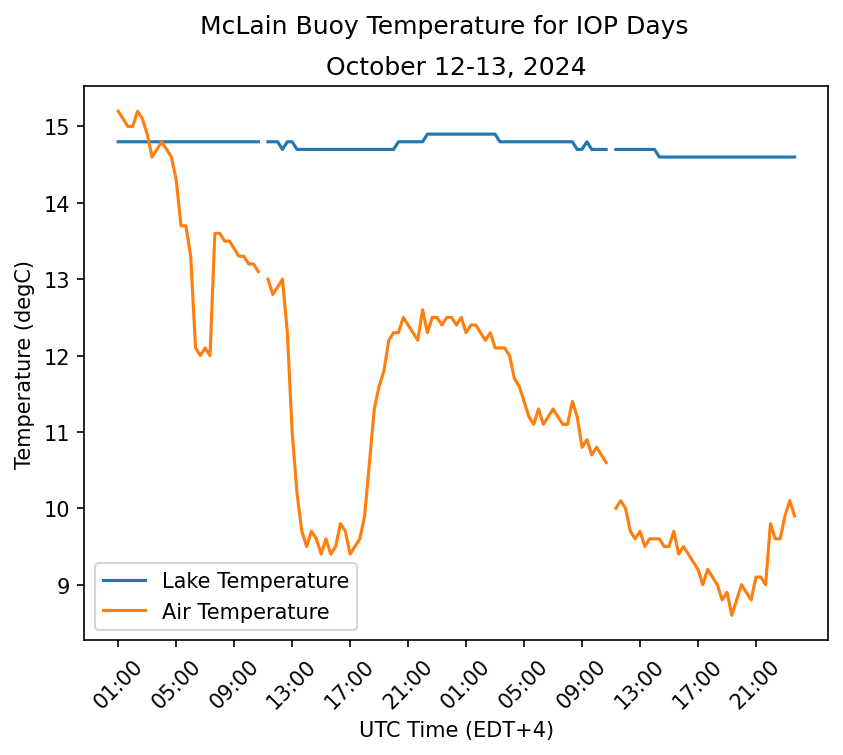

In [109]:
fig=plt.figure(dpi=150)
ax=plt.axes()
ax.plot(iop_days['Date'],iop_days['WTMP'].astype('float64'),label='Lake Temperature')
ax.plot(iop_days['Date'],iop_days['ATMP'].astype('float64'),label='Air Temperature')
ax.set_title(days)
xlabels=(iop_days['hh'].astype('str')+':'+iop_days['mm'].astype('str'))[::12]
ax.set_xticks(np.arange(0,len(iop_days['Date'])+1,12.0), labels=xlabels, rotation=45)
plt.suptitle(f"{site} Buoy Temperature for IOP Days")
ax.set_ylabel('Temperature (degC)')
ax.set_xlabel('UTC Time (EDT+4)')

plt.legend()